In [157]:
import math


class Value:
    def __init__(self, data, _childern=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_childern)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other): # self /  other
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data ** (other -1)) * out.grad
        out._backward = _backward
        return out

    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()

In [158]:
# Visuluze the expression graph

from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') not for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is results of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # add connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+ n2._op)
    
    return dot

In [159]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813, label= 'b')

x1w1 = x1*w1; x1w1.label = "x1 * w1"
x2w2 = x2*w2; x2w2.label = "x2 * w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2. label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()



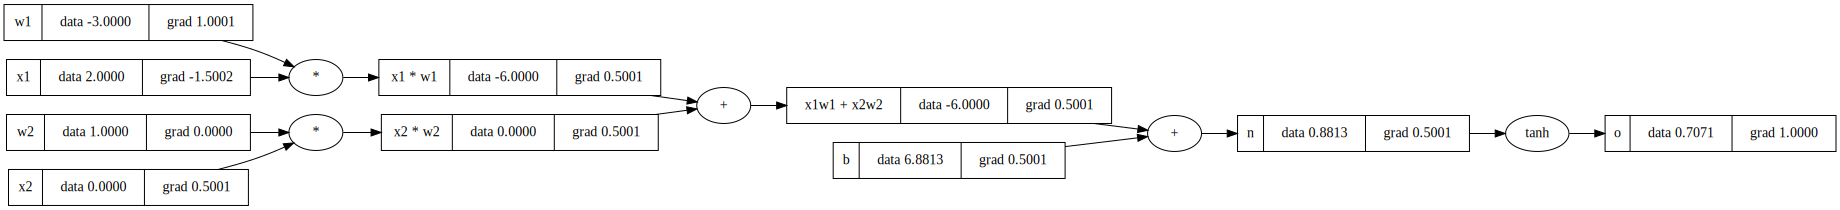

In [160]:
draw_dot(o)

In [161]:
import random 

class Neuron:
    """
    Single neuron that computes tanh(w·x + b).
    
    Attributes:
        w: List of weight Values for each input
        b: Bias Value
    """

    def __init__(self, num_inputs_for_neuron):
        """
        Initialize neuron with random weights and bias.
        
        Args:
            num_inputs_for_neuron (int): Number of inputs
        """
        self.w = [Value(random.uniform(-1,1)) for _ in range(num_inputs_for_neuron)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        """
        Forward pass: computes weighted sum + bias, applies tanh.
        
        Args:
            x (list): Input Value objects
            
        Returns:
            Value: Activated output
        """
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # w * x + b
        out = act.tanh()  # apply activation
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    """
    Layer of neurons that process the same inputs in parallel.
    
    Attributes:
        neurons (list): Neuron objects in this layer
    """

    def __init__(self, num_inputs_for_neuron, num_nueurons_in_layer):
        """
        Initialize layer with multiple neurons.
        
        Args:
            num_inputs_for_neuron (int): Inputs per neuron
            num_nueurons_in_layer (int): Number of neurons
        """
        self.neurons = [Neuron(num_inputs_for_neuron) for _ in range (num_nueurons_in_layer)]
    
    def __call__(self, x):
        """
        Forward pass through all neurons.
        
        Args:
            x (list): Input Value objects
            
        Returns:
            list: Output Value from each neuron
        """
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
        
    def parameters(self):
        params = []
        for neuron in self.neurons:
          p = neuron.parameters()
          params.extend(p)
        return params

    
class MLP:
    """
    Multi-Layer Perceptron: sequential feedforward neural network.
    
    Attributes:
        layers (list): Layer objects that make up the network
    """
    
    def __init__(self, num_inputs, num_outputs_array):
        """
        Initialize MLP with specified architecture.
        
        Args:
            num_inputs (int): Number of input features
            num_outputs_array (list): Neurons per layer, e.g. [16, 16, 1]
        """
        sz = [num_inputs] + num_outputs_array
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(num_outputs_array))]
    
    def __call__(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (list): Input Value objects
            
        Returns:
            list or Value: Network output
        """
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [162]:
# Example

# define network:
# 3 inputs in each data point, 3 layers
n = MLP(3, [4, 4, 1])


# data points
xs = [
        [2.0, 3.0, -1.0], 
        [3.0, -1.0, 0.5], 
        [0.5, 1.0, 1.0], 
        [1.0, 1.0, -1.0]
    ]
# y values (real)
ys = [1.0, -1.0, -1.0, 1.0]

# run the network on all the examples, and get a prediction for each:
ypred = [n(x) for x in xs]

# calculate the loss over all examples:
loss = sum([(pred - y)**2 for y, pred in zip(ys, ypred)], Value(0))

In [173]:
print(loss)

Value(data=5.256012193758859)


In [163]:
# loss is the sum we calaculated for all the example, it's the final node in the graph.
# we can run 'backwards' on it, to calaculate the gradients

loss.backward()

In [165]:
# we can look at the values of data, and grad for each paramerter in the network!
n.layers[0].neurons[0].w[0].data

0.7493683530160005

In [169]:
# using the paramerted funcation we can see all the params in the netwrok
print(len(n.parameters()))

lr = 0.01
# we can also do manual gradient decent, based on the values for each param:
for p in n.parameters():
    p.data += -lr * p.grad 

41


In [176]:
# Training!
for k in range(10):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(pred - y)**2 for y, pred in zip(ys, ypred)], Value(0))

    # zero_grad
    for p in n.parameters():
        p.grad = 0

    # backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -lr * p.grad
    
    print(k, loss.data)

0 0.00012160740448265079
1 0.00012156773966607172
2 0.00012152944820514164
3 0.00012148986523696275
4 0.00012145303736096167
5 0.00012141354216887795
6 0.00012137540987536012
7 0.0001213386585887015
8 0.00012131179581105527
9 0.00012128364673625644
